### Diffusion Equation Backward Euler and Neumann Boundary Condition

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline

In [12]:
class gas_canistor:
    def __init__(self, loc = 0.5, radius = 0.05, concentration = 1.0):
        self.radius = radius
        self.loc = loc
        self.lower_bound = self.loc - self.radius
        self.upper_bound = self.loc + self.radius
        self.concentration = concentration

def f(canistor: gas_canistor, x: np.array):
    return np.where((x >= canistor.lower_bound) & (x <= canistor.upper_bound), 1, 0)

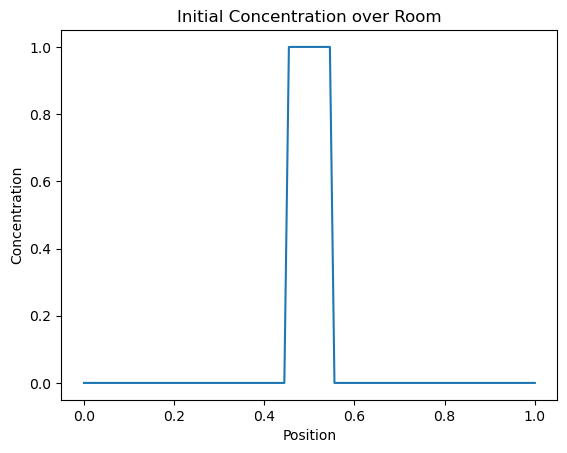

In [13]:
can_1 = gas_canistor()
x = np.linspace(0.0, 1.0, 100)
concentrations = f(can_1, x)

plt.plot(x, concentrations)
plt.title('Initial Concentration over Room')
plt.ylabel('Concentration')
plt.xlabel('Position')
plt.savefig("toy_problem_initial_concentration.svg")

In [14]:
# exact solution
def U_exact(x,t, d = 0.1, c = 0.5):
    M = np.size(x)
    u_ex = d*np.ones(M)  

    start = c - d/2
    end = c + d/2
    
    for s in range(1,1000): 
        npi= s*np.pi
        c_n = 2*(np.sin(npi*end)-np.sin(npi*start))/npi                          
        u_ex = u_ex + c_n*np.cos(npi*x)*np.exp(-npi*npi*t)
        
    return u_ex

In [15]:
class scrubber():
    def __init__(self, location=0.3, radius=0.05, efficiency=0.2):
        self.loc = location
        self.radius = radius
        self.efficiency = efficiency
        self.lower_bound = self.loc - self.radius
        self.upper_bound = self.loc + self.radius

def sink(scrub:scrubber, x, u, dx, capacity):
    """
    loc: location of sink
    x: position
    cot: concentration
    dx: point distances
    capacity: remaining scrubber capacity
    """
    scrub_loc = np.where((x >= scrub.lower_bound) & (x <= scrub.upper_bound))
    intake = scrub.efficiency * u[scrub_loc]
    
    # Trapezoidal rule formula for intake currently
    integral = dx * (0.5 * intake[0] + 0.5 * intake[-1] + np.sum(intake[1:-1]))
    
    # Checks if scrubber can take full intake
    if integral <= capacity:
        u[scrub_loc] = u[scrub_loc] - intake
        return u, integral

    # If the scrubber would reach capacity with full intake
    else:
        intake = intake * sum(capacity/integral)
        u[scrub_loc] = u[scrub_loc] - intake
        return u, capacity
        

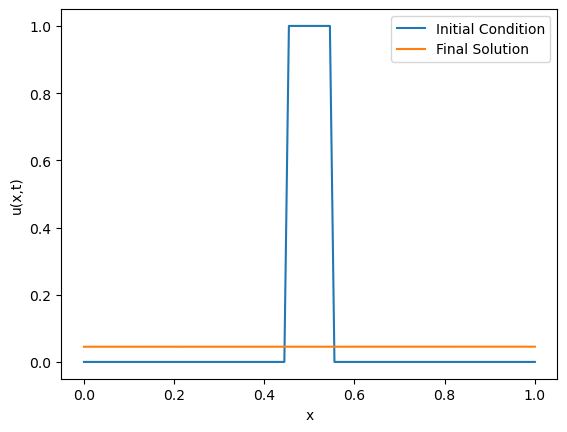

In [30]:
# Parameters
L = 1.0                 # Length of interval
T = 1.0                 # Total time
Nx = 100                # Number of spatial points
Nt = 100                # Number of time steps

dx = L / (Nx - 1)       # Spatial step size
dt = T / Nt             # Time step size
C = dt / dx**2 

capacity = 0.05         # Total  scrubber capacity 
capacity_ex = 0.01      # Total  scrubber capacity for exact solution

x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

canistor = gas_canistor()
u_initial = f(canistor, x)

u = np.copy(u_initial)
u_ex = np.copy(u_initial)

U = np.zeros((Nx, Nt))
U_ex = np.zeros((Nx, Nt))

A = np.zeros((Nx, Nx))

# Initialise matrices U and U_ex2 for first time step
U[:,0] = u
U_ex[:,0] = u_ex

for i in range(1, Nx - 1):
    A[i, i - 1] = -C
    A[i, i] = 1 + 2 * C
    A[i, i + 1] = -C

A[0, 0] = 1 + 2 * C
A[0, 1] = -2 * C   
A[Nx - 1, Nx - 2] = -2 * C 
A[Nx - 1, Nx - 1] = 1 + 2 * C


for n in range(1, Nt):
    u = np.linalg.solve(A, u)
    if capacity > 0:
        vec = sink(scrubber(), x, u, dx, 0.1)        
        u = vec[0]
        capacity -= vec[1]
    U[:,n] = u

    u_ex = U_exact(x,t[n])
    
    if capacity_ex > 0:
        vec = sink(scrubber(), x, u_ex, dx, 0.1)        
        u_ex = vec[0]
        capacity_ex -= vec[1]
    
    U_ex[:,n] = u_ex
    

# Plotting the final solution
plt.plot(x, u_initial, label="Initial Condition")
plt.plot(x, u, label="Final Solution")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.show()

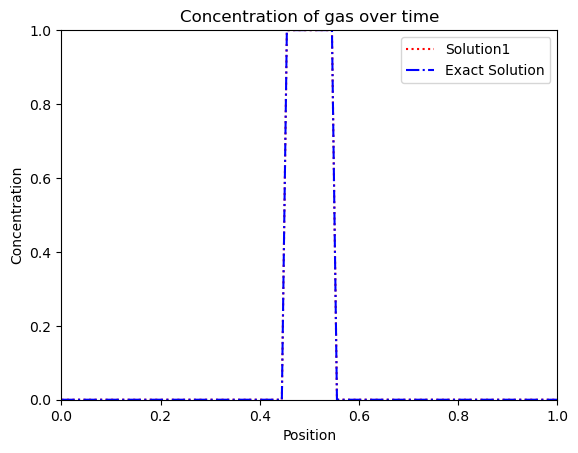

In [31]:
# Set up animation plots
fig, ax = plt.subplots()
ax.axis([0,1,0,1])
def animate(i):
    l.set_data(x, U[:,i])
    m.set_data(x, U_ex[:,i])
    
ax.axis([0,1,0,1.0])
l, = ax.plot([],[],':r', label = "Solution1")
m, = ax.plot([],[],'-.b', label = "Exact Solution")

# Add titles and axis labels
ax.set_title("Concentration of gas over time")
ax.set_xlabel("Position")
ax.set_ylabel("Concentration")

# Add a legend
plt.legend()

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames = Nt)

from IPython.display import HTML
HTML(ani2.to_jshtml())